Nombre de classes: 10
Classes: ['ADVE', 'Email', 'Form', 'Letter', 'Memo', 'News', 'Note', 'Report', 'Resume', 'Scientific']
Nombre total d'images: 348


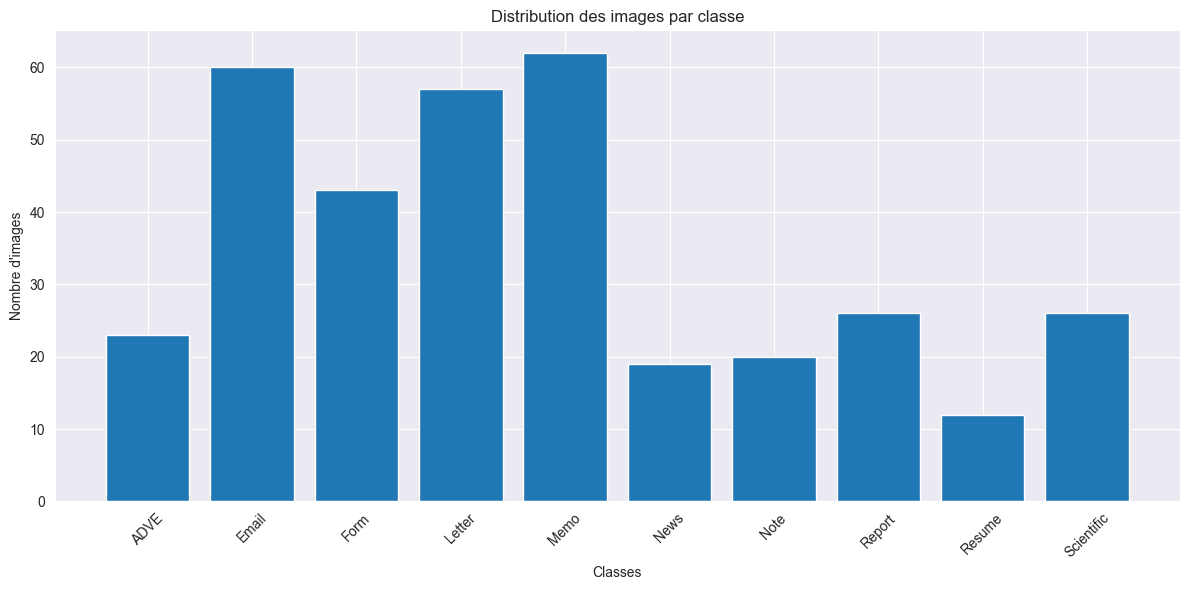

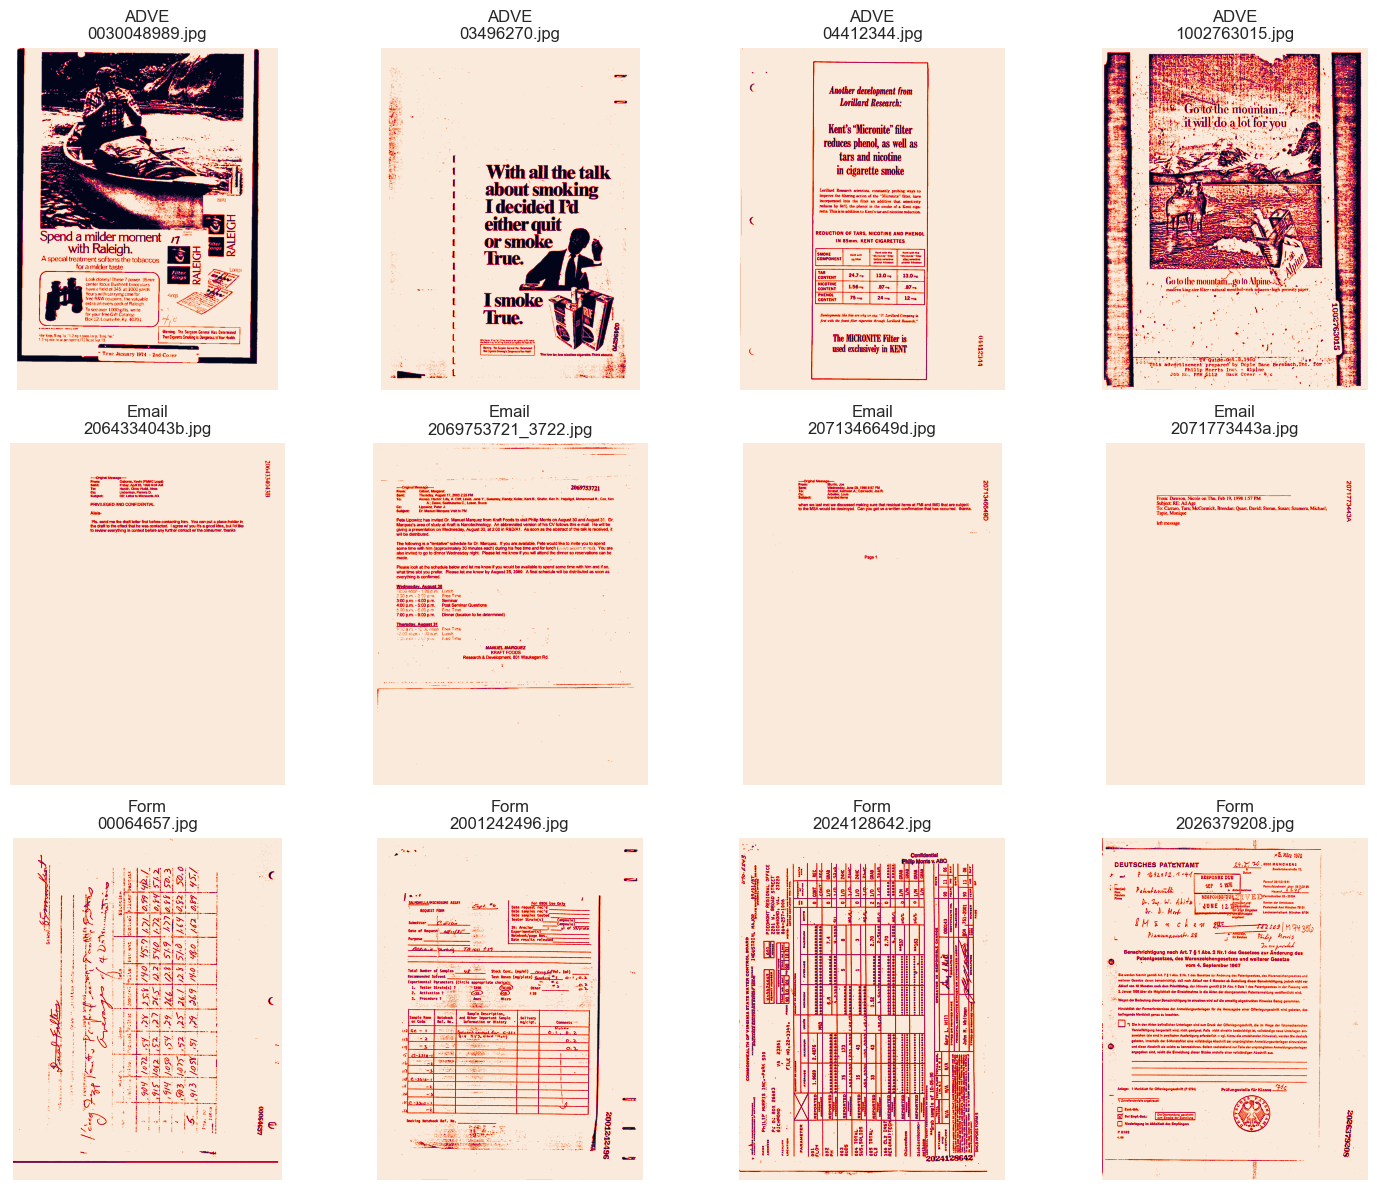

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# Q1-Q3: 数据集探索
def explore_dataset(dataset_path):
    # 获取所有类别
    classes = os.listdir(dataset_path)
    print(f"Nombre de classes: {len(classes)}")
    print(f"Classes: {classes}")
    
    # 统计每类图像数量
    class_counts = {}
    image_paths = []
    labels = []
    
    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)
            class_counts[class_name] = len(images)
            
            # 收集所有图像路径和标签
            for img in images:
                image_paths.append(os.path.join(class_path, img))
                labels.append(class_name)
    
    print(f"Nombre total d'images: {sum(class_counts.values())}")
    
    # Q2: 绘制直方图
    plt.figure(figsize=(12, 6))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title('Distribution des images par classe')
    plt.xlabel('Classes')
    plt.ylabel('Nombre d\'images')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Q3: 可视化示例图像
    fig, axes = plt.subplots(3, 4, figsize=(15, 12))
    axes = axes.ravel()
    
    displayed_classes = 0
    current_axis = 0
    
    for class_name in classes[:3]:  # 显示前3个类别
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)[:4]  # 每个类别显示4张
            
            for i, img_name in enumerate(images):
                img_path = os.path.join(class_path, img_name)
                img = Image.open(img_path)
                
                axes[current_axis].imshow(img)
                axes[current_axis].set_title(f'{class_name}\n{img_name}')
                axes[current_axis].axis('off')
                current_axis += 1
    
    plt.tight_layout()
    plt.show()
    
    return image_paths, labels, class_counts

# 使用示例
dataset_path = "./Tobacco3482_subset_10pct"
image_paths, labels, class_counts = explore_dataset(dataset_path)

In [6]:
import pytesseract
from PIL import Image
import pandas as pd

# Q4: OCR函数
def ocr_image(image_path):
    """
    从图像中提取文本
    """
    try:
        # 打开图像
        img = Image.open(image_path)
        
        # 使用Tesseract提取文本
        text = pytesseract.image_to_string(img, lang='eng')
        
        return text.strip()
    
    except Exception as e:
        print(f"Erreur OCR pour {image_path}: {e}")
        return ""

# Q5: 创建DataFrame
def create_ocr_dataframe(image_paths, labels, sample_size=0.1):
    """
    创建包含OCR结果的DataFrame
    sample_size: 使用数据的比例 (0.1 = 10%)
    """
    # 抽样数据
    total_samples = int(len(image_paths) * sample_size)
    indices = np.random.choice(len(image_paths), total_samples, replace=False)
    
    data = []
    for idx in indices:
        image_path = image_paths[idx]
        label = labels[idx]
        
        print(f"Traitement OCR: {image_path}")
        text = ocr_image(image_path)
        
        data.append({
            'image_path': image_path,
            'label': label,
            'text_ocr': text
        })
    
    return pd.DataFrame(data)

# 创建OCR DataFrame
df_ocr = create_ocr_dataframe(image_paths, labels, sample_size=0.1)

# Q6: 检查OCR结果
def inspect_ocr_results(df, n_samples=3):
    """
    检查OCR结果
    """
    for i in range(min(n_samples, len(df))):
        row = df.iloc[i]
        print(f"\n--- Exemple {i+1} ---")
        print(f"Classe: {row['label']}")
        print(f"Image: {row['image_path']}")
        print(f"Texte OCR (premieres 200 caracteres):")
        print(row['text_ocr'][:200] + "...")
        print("-" * 50)

inspect_ocr_results(df_ocr)

Traitement OCR: ./Tobacco3482_subset_10pct\News\2001222207.jpg
Erreur OCR pour ./Tobacco3482_subset_10pct\News\2001222207.jpg: tesseract is not installed or it's not in your PATH. See README file for more information.
Traitement OCR: ./Tobacco3482_subset_10pct\Scientific\2028719331.jpg
Erreur OCR pour ./Tobacco3482_subset_10pct\Scientific\2028719331.jpg: tesseract is not installed or it's not in your PATH. See README file for more information.
Traitement OCR: ./Tobacco3482_subset_10pct\Form\2051160492.jpg
Erreur OCR pour ./Tobacco3482_subset_10pct\Form\2051160492.jpg: tesseract is not installed or it's not in your PATH. See README file for more information.
Traitement OCR: ./Tobacco3482_subset_10pct\Memo\1002404594.jpg
Erreur OCR pour ./Tobacco3482_subset_10pct\Memo\1002404594.jpg: tesseract is not installed or it's not in your PATH. See README file for more information.
Traitement OCR: ./Tobacco3482_subset_10pct\ADVE\502472358.jpg
Erreur OCR pour ./Tobacco3482_subset_10pct\ADVE\502472

In [5]:
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk

# 下载停用词数据
nltk.download('stopwords')

# Q5: 文本清洗
def clean_text(text):
    """
    清洗文本数据
    """
    if not isinstance(text, str):
        return ""
    
    # 转换为小写
    text = text.lower()
    
    # 移除标点符号
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # 移除数字（可选）
    text = re.sub(r'\d+', '', text)
    
    # 移除多余空格
    text = ' '.join(text.split())
    
    return text

def remove_stopwords(text):
    """
    移除停用词
    """
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

# 应用文本预处理
df_ocr['cleaned_text'] = df_ocr['text_ocr'].apply(clean_text)
df_ocr['processed_text'] = df_ocr['cleaned_text'].apply(remove_stopwords)

print(df_ocr)

# Q6: 构建TF-IDF矩阵
def build_tfidf_matrix(df, max_features=5000):
    """
    构建TF-IDF矩阵
    """
    # 初始化TF-IDF Vectorizer
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        min_df=2,
        max_df=0.8,
        stop_words='english',
        ngram_range=(1, 2)  # 包含单字和双字词组
    )
    
    # 拟合和转换文本数据
    tfidf_matrix = vectorizer.fit_transform(df['processed_text'])
    
    # Q8: 分析词汇表
    feature_names = vectorizer.get_feature_names_out()
    print(f"Taille du vocabulaire: {len(feature_names)}")
    print(f"Forme de la matrice TF-IDF: {tfidf_matrix.shape}")
    
    # 显示一些重要特征
    print("\nQuelques caractéristiques importantes:")
    print(feature_names[:20])
    
    return tfidf_matrix, vectorizer

# 构建TF-IDF矩阵
tfidf_matrix, vectorizer = build_tfidf_matrix(df_ocr)

                                           image_path       label text_ocr  \
0   ./Tobacco3482_subset_10pct\Scientific\85710569...  Scientific            
1        ./Tobacco3482_subset_10pct\Note\87927212.jpg        Note            
2      ./Tobacco3482_subset_10pct\Memo\0000488853.jpg        Memo            
3   ./Tobacco3482_subset_10pct\Memo\2073365529_553...        Memo            
4      ./Tobacco3482_subset_10pct\Memo\2062210337.jpg        Memo            
5      ./Tobacco3482_subset_10pct\Form\2082989787.jpg        Form            
6    ./Tobacco3482_subset_10pct\Email\2083318854a.jpg       Email            
7    ./Tobacco3482_subset_10pct\Email\2085134821a.jpg       Email            
8   ./Tobacco3482_subset_10pct\Email\2085103910d_3...       Email            
9   ./Tobacco3482_subset_10pct\Email\524449506+-95...       Email            
10       ./Tobacco3482_subset_10pct\Memo\01046565.jpg        Memo            
11  ./Tobacco3482_subset_10pct\Letter\50615547-554...      Lette

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\congt\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


ValueError: empty vocabulary; perhaps the documents only contain stop words